# Hospital Readmission within 6 months Prediction

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer

from src.data_visualisation import (plot_class_counts, plot_distributions, plot_binary_distributions, plot_pairplot, 
                                    plot_num_var_histograms, plot_boxplots, plot_outliers_per_subject, plot_outliers_per_feature)
from src.process import (remove_dead_patients, analyze_categorical_features, apply_pca, process_cat_variables,
                         process_binary_variables, check_nan_columns, drop_high_nan_columns, create_exam_feature, analyze_outliers, OutlierToNan, FeatureSelector)
from src.utils import load_data, split_and_save_dataset
from scipy.stats import zscore

%load_ext autoreload
%autoreload 2


### Import and Inspect data

In [2]:
df = load_data('../data/raw/dat.csv')

In [3]:
print("Number of patients:", df.shape[0])
print("Number of features:", df.shape[1])

# Check available features 
print(", \n".join(df.columns))

Number of patients: 2008
Number of features: 167
Unnamed: 0, 
inpatient.number, 
DestinationDischarge, 
admission.ward, 
admission.way, 
occupation, 
discharge.department, 
visit.times, 
gender, 
body.temperature, 
pulse, 
respiration, 
systolic.blood.pressure, 
diastolic.blood.pressure, 
map, 
weight, 
height, 
BMI, 
type.of.heart.failure, 
NYHA.cardiac.function.classification, 
Killip.grade, 
myocardial.infarction, 
congestive.heart.failure, 
peripheral.vascular.disease, 
cerebrovascular.disease, 
dementia, 
Chronic.obstructive.pulmonary.disease, 
connective.tissue.disease, 
peptic.ulcer.disease, 
diabetes, 
moderate.to.severe.chronic.kidney.disease, 
hemiplegia, 
leukemia, 
malignant.lymphoma, 
solid.tumor, 
liver.disease, 
AIDS, 
CCI.score, 
type.II.respiratory.failure, 
consciousness, 
eye.opening, 
verbal.response, 
movement, 
respiratory.support., 
oxygen.inhalation, 
fio2, 
acute.renal.failure, 
LVEF, 
left.ventricular.end.diastolic.diameter.LV, 
mitral.valve.EMS, 
mitral.valve

In [4]:
# Remove dead patients and related features in the dataset
df_no_dead = remove_dead_patients(df)

df_no_dead_future =df_no_dead.drop(['re.admission.within.3.months','re.admission.within.28.days','time.of.death..days.from.admission.',
                                    're.admission.time..days.from.admission.','return.to.emergency.department.within.6.months',
                                    'time.to.emergency.department.within.6.months'], axis=1)


Percentage of patients who died within 6 months: 0.00%

Removed features: death.within.6.months, death.within.3.months, death.within.28.days


Removing death-related features, which account for just 2.84% of the patient data, reduces bias by preventing data leakage. These features provide information about patients that would not be available at prediction time, such as outcomes directly tied to mortality. Including them could skew the model toward unrealistic patterns, such as associating death with no readmission, compromising its ability to generalize to living patients. By excluding these features and removing the small subset of deceased patients, the model can focus on clinically relevant predictors of readmission, ultimately improving fairness, accuracy, and real-world applicability.

### Split dataset into train a test set

In [5]:
train, test = split_and_save_dataset(df_no_dead_future, target_column='re.admission.within.6.months', output_dir='../data/raw/', test_size=0.2, random_state=42)

Train and test sets have been saved to:
- ../data/raw//train.csv
- ../data/raw//test.csv


# Exploratory Data Analysis

re.admission.within.6.months
0    938
1    618
dtype: int64


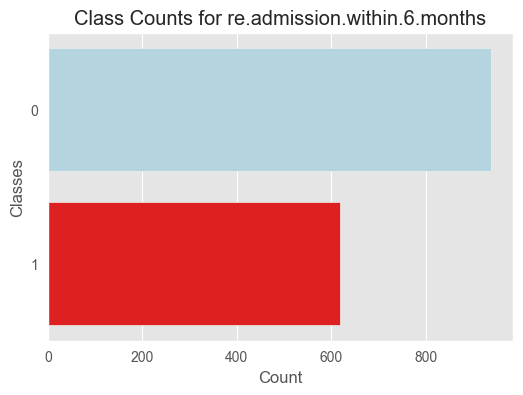

,Unnamed: 0,inpatient.number,DestinationDischarge,admission.ward,admission.way,occupation,discharge.department,visit.times,gender,body.temperature,...,oxygen.saturation,partial.oxygen.pressure,oxyhemoglobin,anion.gap,free.calcium,total.hemoglobin,GCS,dischargeDay,ageCat,re.admission.within.6.months
0,1702,772931,Unknown,Cardiology,Emergency,UrbanResident,Cardiology,1,Male,37.7,...,NaN,NaN,NaN,NaN,NaN,NaN,15,8,"(69,79]",0
1,1149,807688,Home,Cardiology,NonEmergency,UrbanResident,Cardiology,1,Female,36.4,...,98.0,115.0,97.6,14.7,1.10,105.0,15,4,"(49,59]",0
2,596,761208,Home,Cardiology,NonEmergency,Others,Cardiology,1,Female,36.2,...,97.0,98.0,96.8,14.5,1.16,130.0,15,8,"(69,79]",1
3,160,739419,Home,Cardiology,Emergency,UrbanResident,Cardiology,1,Female,36.5,...,NaN,NaN,NaN,NaN,NaN,NaN,15,7,"(79,89]",1
4,1272,760934,Home,Cardiology,NonEmergency,UrbanResident,Cardiology,1,Male,36.8,...,NaN,NaN,NaN,NaN,NaN,NaN,15,11,"(69,79]",0


In [6]:
x = train.copy()
y = train['re.admission.within.6.months']

# Plot class counts
%matplotlib inline
plot_class_counts(x, 're.admission.within.6.months')

#Check Dataframe
x.head()

In [7]:
# Split into numerical and categorical variables based on dtypes
numerical_df = x.select_dtypes(include=['int64', 'float64'])  # Numerical features
categorical_df = x.select_dtypes(include=['object'])  # Categorical features

# Print numerical variables in a readable format
print("Numerical Variables:")
print("\n".join(numerical_df.columns))

# Print categorical variables in a readable format
print("Categorical Variables:")
print("\n".join(categorical_df.columns))

Numerical Variables:
Unnamed: 0
inpatient.number
visit.times
body.temperature
pulse
respiration
systolic.blood.pressure
diastolic.blood.pressure
map
weight
height
BMI
myocardial.infarction
congestive.heart.failure
peripheral.vascular.disease
cerebrovascular.disease
dementia
Chronic.obstructive.pulmonary.disease
connective.tissue.disease
peptic.ulcer.disease
diabetes
moderate.to.severe.chronic.kidney.disease
hemiplegia
leukemia
malignant.lymphoma
solid.tumor
liver.disease
AIDS
CCI.score
eye.opening
verbal.response
movement
fio2
acute.renal.failure
LVEF
left.ventricular.end.diastolic.diameter.LV
mitral.valve.EMS
mitral.valve.AMS
EA
tricuspid.valve.return.velocity
tricuspid.valve.return.pressure
creatinine.enzymatic.method
urea
uric.acid
glomerular.filtration.rate
cystatin
white.blood.cell
monocyte.ratio
monocyte.count
red.blood.cell
coefficient.of.variation.of.red.blood.cell.distribution.width
standard.deviation.of.red.blood.cell.distribution.width
mean.corpuscular.volume
hematocrit
lymp

## Categorical Features

In [8]:
# Check for nan and analyse the categories for each feature
analyze_categorical_features(categorical_df)

# Remove 'respiratory.support.' since it contains most of nan
df_cat = categorical_df.copy()
df_cat.drop('respiratory.support.', axis=1, inplace=True)

Categorical Feature Analysis

Missing Values:
                      Count  Percentage
occupation               22    1.413882
respiratory.support.   1528   98.200514

Value Counts:
DestinationDischarge
Home                  1059
HealthcareFacility     342
Unknown                155
Name: count, dtype: int64
Total Unique Values: 3
----------------------------------------
admission.ward
Cardiology     1199
GeneralWard     206
Others          139
ICU              12
Name: count, dtype: int64
Total Unique Values: 4
----------------------------------------
admission.way
NonEmergency    821
Emergency       735
Name: count, dtype: int64
Total Unique Values: 2
----------------------------------------
occupation
UrbanResident    1289
farmer            155
Others             71
worker             12
Officer             7
Name: count, dtype: int64
Total Unique Values: 5
----------------------------------------
discharge.department
Cardiology     1324
GeneralWard     192
Others           36
ICU   

In [9]:
%matplotlib qt

plot_distributions(df_cat, y, 're.admission.within.6.months')

From this representation, it is clear that some variables are not at all discriminative (within a category, there is not such different regarding the variable to predict). The following features were dropped:
- 'admission.way', 
- 'discharge.department', 
- 'type.II.respiratory.failure', 
- 'consciousness',
- 'oxygen.inhalation', 

In [10]:
df_cat_final = process_cat_variables(df_cat)

plot_distributions(df_cat_final, y, 're.admission.within.6.months')


#### Binary variables

In [11]:
# Binary variables as categorical
binary_variables= ['myocardial.infarction','congestive.heart.failure','peripheral.vascular.disease','cerebrovascular.disease',
                   'dementia','Chronic.obstructive.pulmonary.disease','connective.tissue.disease','peptic.ulcer.disease',
                   'diabetes','moderate.to.severe.chronic.kidney.disease','hemiplegia','leukemia','malignant.lymphoma',
                   'solid.tumor','liver.disease','AIDS','acute.renal.failure']

# Add binary variables to the categorical dataframe                   
df_binary = numerical_df[binary_variables]

# Drop binary variables from the numerical dataframe
df_numerical = numerical_df.drop(labels=binary_variables, axis=1, inplace=False)

df_binary

,myocardial.infarction,congestive.heart.failure,peripheral.vascular.disease,cerebrovascular.disease,dementia,Chronic.obstructive.pulmonary.disease,connective.tissue.disease,peptic.ulcer.disease,diabetes,moderate.to.severe.chronic.kidney.disease,hemiplegia,leukemia,malignant.lymphoma,solid.tumor,liver.disease,AIDS,acute.renal.failure
0,0,1,0,0,0,0,0,0.0,0,0.0,0,0,0,0,0.0,0,0
1,0,1,0,0,0,0,1,0.0,0,0.0,0,0,0,0,0.0,0,0
2,0,1,0,0,1,0,0,0.0,0,0.0,0,0,0,0,0.0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1553,0,1,0,0,0,0,0,0.0,0,0.0,0,0,0,0,0.0,0,0
1554,0,1,0,1,0,0,0,0.0,0,0.0,0,0,0,0,0.0,0,0
1555,0,1,0,0,0,0,0,0.0,1,0.0,0,0,0,0,0.0,0,0


In [12]:
analyze_categorical_features(df_binary)
plot_distributions(df_binary, y, 're.admission.within.6.months')
# plot_binary_distributions(df_binary, y, 're.admission.within.6.months')

Categorical Feature Analysis

Missing Values:
                                           Count  Percentage
peptic.ulcer.disease                           1    0.064267
moderate.to.severe.chronic.kidney.disease      2    0.128535
liver.disease                                  1    0.064267

Value Counts:
myocardial.infarction
0    1447
1     109
Name: count, dtype: int64
Total Unique Values: 2
----------------------------------------
congestive.heart.failure
1    1458
0      98
Name: count, dtype: int64
Total Unique Values: 2
----------------------------------------
peripheral.vascular.disease
0    1480
1      76
Name: count, dtype: int64
Total Unique Values: 2
----------------------------------------
cerebrovascular.disease
0    1444
1     112
Name: count, dtype: int64
Total Unique Values: 2
----------------------------------------
dementia
0    1470
1      86
Name: count, dtype: int64
Total Unique Values: 2
----------------------------------------
Chronic.obstructive.pulmonary.disease

In [13]:
df_binary_new_var = process_binary_variables(df_binary)

plot_distributions(df_binary_new_var, y, 're.admission.within.6.months')

var_to_drop = ['myocardial.infarction','peripheral.vascular.disease','cerebrovascular.disease',
               'AIDS','acute.renal.failure','hemiplegia','leukemia','malignant.lymphoma','solid.tumor','liver.disease','connective.tissue.disease','peptic.ulcer.disease','dementia',
                'Chronic.obstructive.pulmonary.disease', 'cancer', 'chronic_heart_pulmonary_disease']
df_bin_final = df_binary_new_var.drop(var_to_drop, axis=1)

plot_distributions(df_bin_final, y, 're.admission.within.6.months')

## Analyse Ordinal variables

In [14]:
ordinal_features=['visit.times','CCI.score','eye.opening','verbal.response','movement','GCS']

df_ordinal = df_numerical[ordinal_features]

plot_distributions(df_ordinal, y, 're.admission.within.6.months')

# keep only 'CCI.score' and as a numerical, the others do not seem relevant
df_num = df_numerical.drop(labels=['visit.times','eye.opening','verbal.response','movement','GCS'], axis=1)
df_num

,Unnamed: 0,inpatient.number,body.temperature,pulse,respiration,systolic.blood.pressure,diastolic.blood.pressure,map,weight,height,...,carboxyhemoglobin,body.temperature.blood.gas,oxygen.saturation,partial.oxygen.pressure,oxyhemoglobin,anion.gap,free.calcium,total.hemoglobin,dischargeDay,re.admission.within.6.months
0,1702,772931,37.7,106,19,105,60,75.000000,46.0,1.70,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8,0
1,1149,807688,36.4,85,19,124,64,84.000000,55.0,1.60,...,0.1,37.0,98.0,115.0,97.6,14.7,1.10,105.0,4,0
2,596,761208,36.2,92,19,146,82,103.333333,53.0,1.50,...,0.3,37.0,97.0,98.0,96.8,14.5,1.16,130.0,8,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1553,1672,831820,36.4,80,17,106,64,78.000000,49.0,1.60,...,1.0,37.0,99.0,161.0,97.1,15.4,1.07,83.0,10,1
1554,707,843341,36.2,63,18,120,86,97.333333,49.0,1.45,...,0.1,37.0,98.0,125.0,98.1,17.1,1.16,134.0,8,0
1555,436,738288,36.2,76,18,130,66,87.333333,67.5,1.55,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8,1


## Numerical Features

In [15]:
check_nan_columns(df_num, threshold=0.3)

# Feature engineering: create variable "exam" and add it to the binary dataframe
df_bin_final = create_exam_feature(df_num, df_bin_final)

df_num_processed = df_num.drop(['Unnamed: 0','inpatient.number'], axis=1)

df_num_no_nan = drop_high_nan_columns(df_num, threshold=0.3)

How many columns with %NaN > 30.0%? 41
left.ventricular.end.diastolic.diameter.LV: 34.51%
reduced.hemoglobin: 50.58%
measured.residual.base: 50.58%
lactate: 50.58%
chloride.ion: 50.58%
potassium.ion: 50.58%
glucose.blood.gas: 50.58%
sodium.ion: 50.58%
hematocrit.blood.gas: 50.58%
partial.pressure.of.carbon.dioxide: 50.58%
methemoglobin: 50.58%
total.carbon.dioxide: 50.58%
standard.bicarbonate: 50.58%
standard.residual.base: 50.58%
pH: 50.58%
measured.bicarbonate: 50.58%
free.calcium: 50.58%
anion.gap: 50.58%
oxyhemoglobin: 50.58%
partial.oxygen.pressure: 50.58%
oxygen.saturation: 50.58%
body.temperature.blood.gas: 50.58%
carboxyhemoglobin: 50.58%
total.hemoglobin: 50.58%
mitral.valve.EMS: 51.09%
high.sensitivity.protein: 52.89%
tricuspid.valve.return.velocity: 60.03%
LVEF: 67.54%
glutamic.oxaliplatin: 70.44%
mitral.valve.AMS: 73.46%
Inorganic.Phosphorus: 79.95%
serum.magnesium: 79.95%
EA: 80.59%
myoglobin: 80.78%
erythrocyte.sedimentation.rate: 85.15%
lipoprotein: 91.45%
apolipoprotein

In [16]:
# Check the distribution of numerical variables
plot_num_var_histograms(df_num_no_nan)

# plot_pairplot(df_num_no_nan, max_features=15)
# only 'glomerular.filtration.rate' seems to be discrimninative

#### Outliers analysis

In [17]:
# %matplotlib inline
# To investigate the presence of outliers, we can also plot the boxplots of these variables:
columns = ['BMI', 'total.bile.acid', 'standard.deviation.of.red.blood.cell.distribution.width']
plot_boxplots(df_num_no_nan, columns)

In [18]:
df_zscored = analyze_outliers(df_num_no_nan)

Train subjects before outlier removal: (1556, 80)


Clearly, not all these values are really outliers: indeed, dealing with pathological conditions, many of these values are due to pathology itself. 
In particular, analyzing each of these features, only the following cases were found to be outliers, probably due to wrong entries:
-  'systolic.blood.pressure', 'diastolic.blood.pressure', 'map' = 0 values. 
- 'weight' = 0, 
- 'height' = 0.35cm
- 'BMI' = 404 


These were converted in NaN values. To do this, we define a class which we will then be able to use in the final Pipeline: this class will convert these specific conditions into NaN and will, in the end, drop the features characterized by a percentage of NaN values > 40%.

In [19]:
# Create an instance of the transformer
outlier_transformer = OutlierToNan(move_outliers=True, nan_threshold=0.4)

# Apply it to a DataFrame
df_num_final  = outlier_transformer.transform(df_num_no_nan)

#### NaN values analysis

As already said, features with a percentage of nan > 30% were simply removed from the dataset, since the imputation would have been biased and deleting the rows would have reduced the sample size too much. 

For the remaining variables, different possibilities were investigated, namely:
- Simple Imputation with mean
- Simple Imputation with median
- Iterative Imputation (MICE) considering a different number of nearest features (10,12,15). 

The following lines of code will show this analysis, which follows these steps:
1) Split the training fold into numerical and categorical variables, as shown above. 
3) Apply different imputation methods and verify which brings to a better f1 score.

In [20]:
import numpy as np
import pandas as pd

# df_num_final
# df_bin_final
# df_cat_final


In [21]:
from sklearn.ensemble import RandomForestClassifier
from src.process import evaluate_imputation_methods
from src.data_visualisation import plot_imputation_results
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import GradientBoostingClassifier


y = df_num_final['re.admission.within.6.months']  
df_num_final_cleaned = df_num_final.drop(columns=['re.admission.within.6.months'])

logreg_model = make_pipeline(
    StandardScaler(),  # Ensure the features are scaled
    LogisticRegression(solver='lbfgs', max_iter=1000, random_state=0)  # Increase max_iter
)

gb_model = GradientBoostingClassifier(random_state=0)
rf_model = RandomForestClassifier(random_state=0)

# Call the function with Random Forest
scores = evaluate_imputation_methods(df_num_final_cleaned, y, rf_model)

plot_imputation_results(scores)
print(scores)

  SimpleImputer           IterativeImputer                    
           mean    median               10        12        15
0      0.355401  0.360544         0.334471  0.327402  0.366102
1      0.364780  0.393750         0.382716  0.377358  0.401216
2      0.366667  0.311594         0.390411  0.342657  0.365517


In the end, the Simple Imputer with the mean is enough, since the other results have more variability and the improvement is not significant.

In [22]:
# Apply SimpleImputer to handle missing values
imputer = SimpleImputer(strategy='mean')  # You can change 'mean' to 'median' or 'most_frequent'
df_num_final_imputed = pd.DataFrame(
    imputer.fit_transform(df_num_final_cleaned), 
    columns=df_num_final_cleaned.columns
)

# Check the result
print(f"Missing values remaining: {df_num_final_imputed.isna().sum().sum()}")


Missing values remaining: 0


## Dimensionality Reduction 

### PCA: Principal Component Analysis

In [23]:
df_pc = apply_pca(df_num_final_imputed)

Number of components needed to reach 95% variance: 48


### Sequential Feature Selection 

In [50]:
import tensorflow as tf
# Check the GPU
print(tf.config.list_physical_devices('GPU'))
from keras import backend as K
K._get_available_gpus()

ModuleNotFoundError: No module named 'tensorflow'

In [24]:
# Initialize the estimator
estimator = RandomForestClassifier(random_state=0)

# Initialize the FeatureSelector
selector = FeatureSelector(estimator=estimator, n_features=10, corr_threshold=0.85, scoring='accuracy', cv=3)

# Perform feature selection
X_reduced, selected_features = selector.fit(dataset=df_num_final_imputed, labels=y, corr_based=False, method='SBS')

# Results
print(f"Selected features: {selected_features}")
print(f"Reduced dataset shape: {X_reduced.shape}")

Performing sequential feature selection...


KeyboardInterrupt: 

### Categorical features
The imputation method chosen when dealing with NaN values in categorical features is a SimpleImputer with the mode. 

# Preprocessing and feature selection phase
After this data analysis step, we define a function, called 'processing', which will perform different tasks:

    1) Train-test folds selection: at each iteration, select 3 folds for training and one fold for testing. 

    2) Preprocessing, consisting of different steps for different features. 

For numerical features:

    a. convert outliers to nan and remove features with a percentage of nan > 40%
    b. MICE for imputing missing values
    c. standard scaling

For categorical features: 

    a. SimpleImputer ('most_frequent')
    b. encoding, which can be either OneHot, Ordinal, or nothing, as will be better explained below inside the function. 

    3) Feature Selection, which consists of three steps (two filter methods and one wrapper method):
    
    a. Remove low variance (constant) features 
    b. Remove features characterized by a correlation >0.85: among two correlated features, keep the one which has
     a lower mean correlation with all the other variables. 
    c. Sequential backward selection using a DecisionTreeClassifier

    4) SMOTE (optional): 
    the SMOTE algorithm was one of the investigated choices to deal with the problem of class imbalance. This algorithm, 
    slightly different from classical Oversampling technique, is a data augmentation technique which creates synthetic 
    instances belonging to the minority class as the result of a convex combination (i.e. a linear combination in which 
    all coefficients are non negative and sum up to 1) between an observation x, randomly selected from the class to 
    augment, and another one y, picked at random as well from the subset of k-nearest neighbors of x. 

    5) Adapt the test set


In [37]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.utils import resample
from sklearn.tree import DecisionTreeClassifier
from imblearn.over_sampling import SMOTE 
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
from mlxtend.feature_selection import SequentialFeatureSelector as sfs
from sklearn.feature_selection import VarianceThreshold 
from itertools import compress
from sklearn.impute import SimpleImputer
from sklearn.experimental import enable_iterative_imputer  
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder

In [38]:
# This function receives as input, at each iteration:
# - the train (train_fold) and test (val_fold) folds obtained, at each iteration, as the concatenation of 
#    three folds for training and one fold for testing 
# - the fold number, meaning the current iteration (ranging from 0 to 3)
# - a boolean parameter to decide whether to perform SMOTE in order to balance the classes or not. 

def processing(train_fold, val_fold, fold_number, oversampling): 


# 1) Train-test folds selection

    X_train_fold=train_fold[fold_number] # train fold 
    X_train= X_train_fold.drop('re.admission.within.6.months', axis=1)
    y_train= X_train_fold['re.admission.within.6.months'].astype(int)
    
    X_val_fold=val_fold[fold_number] # test fold 
    X_test= X_val_fold.drop('re.admission.within.6.months',axis=1)
    y_test=X_val_fold['re.admission.within.6.months'].astype(int)

# 2) Scaling and feature selection 
    # Numerical features 
    # Select numerical variables based on their dtype:
    df_numerical = X_train.select_dtypes(include=['int64','float64']) 

    # Identify binary variables and variables which can assume few values and drop them from the numerical dataframe 
    # to include them in the categorical daraframe. 
    binary_variables= ['myocardial.infarction','congestive.heart.failure','peripheral.vascular.disease','cerebrovascular.disease',
        'dementia','Chronic.obstructive.pulmonary.disease','connective.tissue.disease','peptic.ulcer.disease','diabetes',
        'moderate.to.severe.chronic.kidney.disease','hemiplegia','leukemia','malignant.lymphoma','solid.tumor','liver.disease',
        'AIDS','acute.renal.failure']
    ordinal_variables=['visit.times','CCI.score','eye.opening','verbal.response','movement','GCS']
    df_numerical=df_numerical.drop(labels=binary_variables, axis=1)
    df_numerical=df_numerical.drop(labels = ordinal_variables, axis=1)
    
    # Categorical features
    # Select numerical variables based on their dtype:
    df_categorical = X_train.select_dtypes(include='object')

    # Include 'binary_variables' and 'ordinal_variables' in the categorical dataframe:
    df_categorical= pd.concat([df_categorical,X_train[binary_variables]], axis=1)
    df_categorical= pd.concat([df_categorical,X_train[ordinal_variables]], axis = 1)

    # The Exploratory Data Analysis step performed on the training set corresponding to each iteration of the K fold 
    # cross validaiton revealed some features which never appeared to be significative, based on the graphic representations 
    # seen above. Therefore, they were removed from the dataset:
    variables_to_drop=['eye.opening','verbal.response','movement','admission.ward', 'admission.way', 'discharge.department', 'type.II.respiratory.failure', 'consciousness','respiratory.support.','oxygen.inhalation', 'outcome.during.hospitalization','myocardial.infarction','congestive.heart.failure','peripheral.vascular.disease','cerebrovascular.disease','dementia','Chronic.obstructive.pulmonary.disease','connective.tissue.disease','peptic.ulcer.disease','hemiplegia','leukemia','malignant.lymphoma','solid.tumor','liver.disease','AIDS','acute.renal.failure']
    df_categorical = df_categorical.drop(labels=variables_to_drop, axis=1)

    # The variable 'DestinationDischarge' contained a class called 'Unknown', which we decided to convert to nan 
    # in order to perform an imputation. 
    df_categorical['DestinationDischarge'] = df_categorical['DestinationDischarge'].replace('Unknown',np.nan)
    
    # Define the Numerical Pipeline
    num_attributes=df_numerical.columns # Define numerical attributes
    
    # The following 7 lines of code were defined only to compute the new values of arr_min and arr_max, needed to 
    # bound the values imputed by MICE algorithm between the minimum and maximum they assumed in the original 
    # training set. This was necessary since without these parameters the MICE algorithm generated abnormal values
    # (e.g. negative heights). 
    pipe_to_help = Pipeline([
        ('outlier_to_Nan', Outlier_to_Nan()),
        ])
    new_num = pipe_to_help.fit_transform(df_numerical)
    num_attributes=new_num.columns # This is now changed because the class Outlier_to_NaN removes features with a high
                                   # percentage of nan (>40%): this toy pipeline was needed for this reason, meaning
                                   # to be able to obtain the new column names and the minimum and maximum values
                                   # assumed by features in the training set, needed to perform imputation. 
    arr_min = new_num.min() # define the minimum value assumed by each feature in the training set
    arr_max = new_num.max() # define the maximum value assumed by each feature in the training set
    
    # Numerical Pipeline preprocessing:
        # 1. The class Outlier_to_Nan was created to convert some specific values, which were found to be outliers, to NaN 
        # and treat them as missing values. Moreover, this function also removes the features which have a percentage
        # of NaN values > 40%. 
        # 2. MICE: The iterative Imputer was used to impute missing values. The parameter n_nearest_features was set to 10 
        # after verifying it was the one which guaranteed a better performance with respect to other values (12, 15), 
        # as shown above. 
        # 3. Standard Scaling
    num_pipeline = Pipeline([
        ('outlier_to_Nan', Outlier_to_Nan()), 
        ('imputer', IterativeImputer(
            missing_values=np.nan,
            random_state=0,
            sample_posterior=True,
            n_nearest_features = 10,
            min_value = arr_min,
            max_value = arr_max
        )), 
        ('std_scaler', StandardScaler()),
        ])
    
    # Define the Categorical Pipelines 
   
   # Define the total amount of 'binary features' which were kept after dropping non discriminative variables:
    binarie = ['diabetes','moderate.to.severe.chronic.kidney.disease','gender', 'type.of.heart.failure','exam','DestinationDischarge']
    # Define the total amount of 'ordinal features' which were kept after dropping non discriminative variables:
    ordinali = ['visit.times', 'NYHA.cardiac.function.classification', 'Killip.grade', 'CCI.score', 'GCS','ageCat']
    df_categorical= pd.concat([df_categorical[ordinali],df_categorical[binarie]], axis = 1)

    # The preprocessing steps to perform were different for the various features and we will therefore define three
    # Pipelines: the common step is the imputation with 'most_frequent'. 
    # The difference stands in the encoding phase:
    # 1. 'dummy_pipeline': for features which need to be encoded through one-hot encoding ('cat_attribs_dummy');
    # 2. 'ord_pipeline': for features which need to be encoded with the OrdinalEncoder because they have an intrinsic
    # order ('cat_attribs_ord'); 
    # 3. 'cat_pipeline': for features which need no encoding ('cat_attributes'): these include both binary variables 
    # which are already in one-hot format ('diabetes', 'moderate.to.severe.chronic.kidney.disease'), and features 
    # which were converted from numerical to categorical and therefore already have an intrinsic order ('visit.times',
    # 'CCI.score', 'GCS').
    
    cat_attribs_dummy = ['gender', 'type.of.heart.failure','exam','DestinationDischarge']
    cat_attribs_ord = ['NYHA.cardiac.function.classification', 'Killip.grade', 'ageCat']
    cat_attributes = ['diabetes','moderate.to.severe.chronic.kidney.disease','visit.times','CCI.score', 'GCS']

    dummy_pipeline = Pipeline([
        ('imputer', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
        ('onehot', OneHotEncoder(handle_unknown = 'ignore', drop = 'first')),
        ])

    ord_pipeline = Pipeline([
        ('imputer', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
        ('ordinal', OrdinalEncoder(handle_unknown = 'use_encoded_value', unknown_value = -1)),
        ('std_scaler', StandardScaler())
        ])

    cat_pipeline = Pipeline([
        ('imputer', SimpleImputer(missing_values=np.nan, strategy='most_frequent'))
        ])

    # Concatenate the numerical and categorical pipelines, to obtain the final full_pipeline, that will perform
    # all the defined preprocessing steps at each iteration of the k-fold cross validation. 
    full_pipeline = ColumnTransformer([
        ("num", num_pipeline, num_attributes), # Outliers_to_NaN, IterativeImputer, StandardScaler
        ("cat_ordinal", ord_pipeline, cat_attribs_ord), # SimpleImputer, OrdinalEncoder
        ("cat_dummy", dummy_pipeline, cat_attribs_dummy), # SimpleImputer, OneHot
        ("cat", cat_pipeline, cat_attributes)]) # SimpleImputer
    
# 3) Feature Selection
# Define a class, called feature selection, to include in the final pipeline.
    class feature_selection(BaseEstimator, TransformerMixin):
        def __init__(self, estimator, n_features, training, corr_based, sequ_based):
            self.estimator = estimator # the regression model to use for performing Sequential Backward feature selection
            self.n_features = n_features # the number of features to keep
            self.training = training # a copy of the training set
            self.corr_based = corr_based # boolean to choose whether to perform the correlation based feature selection or not
            self.sequ_based = sequ_based # boolean to choose whether to perform the Sequential Backward feature selection or not
          
        def fit(self, X, y=None):
            return self  # nothing else to do
        def transform(self, X, y=y_train):
            # We need to re-create the dataframe because after going through preprocessing steps it was lost:
            binary=['diabetes','moderate.to.severe.chronic.kidney.disease']
            cat_attribs_dummy= ['gender', 'type.of.heart.failure','exam','DestinationDischarge']
            dummy_feat_new = pipeline_tot['preprocessing'].transformers_[2][1]\
                                    ['onehot'].get_feature_names_out(cat_attribs_dummy)
            cat_attribs_ord = ['visit.times', 'NYHA.cardiac.function.classification', 'Killip.grade', 'CCI.score', 'GCS','ageCat']
            cols = np.concatenate((num_attributes, cat_attribs_ord, binary, dummy_feat_new))
            X_n = pd.DataFrame(X, index = self.training.index, columns = cols)

            # The first two steps, meaning the two filter methods (variance based and correlation based), are only
            # applied to numerical features and categorical features which have an intrinsic order. 
            items = np.concatenate((num_attributes, cat_attribs_ord))
            X_num = X_n.filter(items = items)

            # 1. Eliminate low variance (contast) features
            vt = VarianceThreshold(threshold=(0.01)) # set the threshold 
            features_var = vt.fit_transform(X_num)
            mask = vt.get_support() 
            features_notconst = X_num.loc[:, mask]
            X_num_new = X_num.drop(list(compress(items, ~mask)), axis=1)
            X_n = X_n.drop(list(compress(items, ~mask)), axis=1)
            
            # 2. Correlation based feature selection
            if self.corr_based: 
                    correlated_features = set() # this will be filled with the features to drop
                    correlation_matrix = X_num_new.corr() # compute pairwise correlation among variables
                    mean_corr = (correlation_matrix.abs()).mean(axis=0) # compute the mean correlation 
                                                                        # among each variable with all the others

                    for i in range(len(correlation_matrix .columns)):
                        for j in range(i):
                            if abs(correlation_matrix.iloc[i, j]) > 0.85: # if the correlation among two variables is > 0.85
                                if mean_corr[i] > mean_corr[j]: #select the variable which is less correlated to the others
                                    colname = correlation_matrix.columns[i]
                                else:
                                    colname = correlation_matrix.columns[j]
                                    
                                correlated_features.add(colname)
                    # Drop the features
                    X_fin = X_n.drop(labels=correlated_features, axis=1, inplace= False) 
                    feat_list_new = X_fin.columns
                    # 3. Sequential backward selection using a DecisionTreeClassifier
                    if self.sequ_based: 
                        tr = X_fin.copy()
                        sfs1 = sfs(self.estimator, k_features = self.n_features, forward=False, verbose=1,  scoring='f1', cv=3)
                        sfs1 = sfs1.fit(tr, y)
                        feat_names = list(sfs1.k_feature_names_)
                        return tr[feat_names], feat_names
                    else: 
                        tr=X_fin.copy()
                        feat_names=feat_list_new 
                        return tr[feat_names], feat_names
            else: 
                tr = X_n.copy()
                sfs1 = sfs(self.estimator, k_features = self.n_features, forward=False, verbose=1, scoring='f1', cv=3) 
                sfs1 = sfs1.fit(tr, y)
                feat_names = list(sfs1.k_feature_names_)
                return tr[feat_names], feat_names
      
    # At this point, we put together numerical and categorical sets and define the total pipeline, which contains 
    # both the preprocessing steps defined above and the feature selection: 
    training = pd.concat([df_numerical, df_categorical], axis = 1)
    est = DecisionTreeClassifier(class_weight='balanced', random_state=42) # estimator for Sequential Backward feature selection
    tr = training.copy()
    pipeline_tot = Pipeline([ 
        ('preprocessing', full_pipeline), 
        ('featureselection', feature_selection(est, 18, training = tr, corr_based=True, sequ_based=True))
        # We perform both correlation based and sequential backward feature selection, using a DecisionTree Classifier
        # and choosing a final number of features equal to 18: this number was obtained by trail and error as
        # the one which guaranteed the best results. 
    ] ) 

    training_prepared_2, feat_names = pipeline_tot.fit_transform(training)
    df_training = pd.DataFrame(training_prepared_2, index = training.index, columns = feat_names)

        
# 4) SMOTE algorithm 
    if oversampling: # apply only if the oversampling parameter in the 'processing' function is set of 'True'
        sm = SMOTE(random_state=42)
        X_res, y_res = sm.fit_resample(df_training, y_train)
        df_training = X_res.copy()
        y_train = y_res.copy()
    
# 5) Adapt test set
    # Numerical features
    df_numerical_test = X_test.select_dtypes(include=['int64','float64'])
    df_numerical_test=df_numerical_test.drop(labels=binary_variables, axis=1)
    df_numerical_test=df_numerical_test.drop(labels = ordinal_variables, axis=1)
    df_numerical_test = df_numerical_test.filter(items = num_attributes)
    
    # Categorical features
    df_categorical_test = X_test.select_dtypes(include='object')
    df_categorical_test= pd.concat([df_categorical_test,X_test[binary_variables]], axis=1)
    df_categorical_test= pd.concat([df_categorical_test,X_test[ordinal_variables]], axis = 1)
    df_categorical_test = df_categorical_test.drop(labels=variables_to_drop, axis=1)
    df_categorical_test['DestinationDischarge'] = df_categorical_test['DestinationDischarge'].replace('Unknown',np.nan)
    df_categorical_test= pd.concat([df_categorical_test[ordinali],df_categorical_test[binarie]], axis = 1)
    
    # Concatenate numerical and categorical 
    testing = pd.concat([df_numerical_test, df_categorical_test], axis = 1)
    testing_prepared = full_pipeline.transform(testing) # Apply the preprocessing pipeline only 
   
    binary=['diabetes','moderate.to.severe.chronic.kidney.disease']
    cat_attribs_dummy= ['gender', 'type.of.heart.failure','exam','DestinationDischarge'] 
    dummy_feat_new = pipeline_tot['preprocessing'].transformers_[2][1]\
            ['onehot'].get_feature_names_out(cat_attribs_dummy)
    cols = np.concatenate((num_attributes, ordinali, binary, dummy_feat_new))
    df_testing = pd.DataFrame(testing_prepared, index = testing.index, columns = cols)
    df_testing = df_testing.filter(items = feat_names) # only select the features which were chosen during the feature 
                                                       # selection phase in the training set
       
    return df_training, df_testing, y_train, y_test

In [39]:
X_train=[]
X_test=[]
y_train = []
y_test = []
# Apply the previously defined function 4 times, to each training and test folds: 
for i in range(len(train_fold)):
    X_train_ready, X_test_ready, y_train_ready, y_test_ready = processing(train_fold, val_fold, i, oversampling=False)
    # The parameter oversampling was finally set to False since SMOTE algorithm didn't seem to improve the performances
    # of the final classifier. The final choice to deal with the unbalanced dataset was to use class weights, computed 
    # as the inverse of the frequency of each class label in the training set, in such a way to penalize more the errors 
    # that the model performs when predicting the minority class.
    
    X_train.append(X_train_ready.copy())
    X_test.append(X_test_ready.copy())
    y_train.append(y_train_ready.copy())
    y_test.append(y_test_ready.copy())

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  77 out of  77 | elapsed:   12.8s finished
Features: 76/18[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  76 out of  76 | elapsed:   11.2s finished
Features: 75/18[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  75 out of  75 | elapsed:   11.1s finished
Features: 74/18[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  74 out of  74 | elapsed:   10.9s finished
Features: 73/18[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  73 out of  73 | elapsed:   11.5s finished
Features: 72/18[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  72 out of  72 | elapsed:   10.6s finished
Features: 71/18[Par

# Model Selection 

In [106]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn import metrics
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import auc
from matplotlib import pyplot
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import ConfusionMatrixDisplay, PrecisionRecallDisplay

# Function to plot the confusion matrix
def plot_confusionMatrix(test_labels, test_predicted):
    cm = confusion_matrix(test_labels, test_predicted)
    cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    disp = ConfusionMatrixDisplay(confusion_matrix=cmn,
                                display_labels=['0', '1'])
    disp.plot()
    plt.show()
    
    # print(confusion_matrix(test_labels, test_predicted))
    print(classification_report(test_labels, test_predicted, target_names=['0','1']))
    return 

# Function to plot the precision-recall curve, which is more appropriate than the ROC curve when dealing with 
# unbalanced datasets. 
def prc(model,X_train,y_train,X_test,y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_probs = model.predict_proba(X_test) 
    y_probs_train = model.predict_proba(X_train)
    precision_train, recall_train, thresholds_train = metrics.precision_recall_curve(y_train,  y_probs_train[:,1])
    precision, recall, thresholds1=metrics.precision_recall_curve(y_test,  y_probs[:,1])
   
    import matplotlib.pyplot as plt
    plt.plot(recall, precision, label='Test')
    plt.plot(recall_train,precision_train, label= "Train")
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend()
    plt.show()
    
    # Area under the Precision-Recall Curve
    auc_precision_recall = metrics.auc(recall, precision)
    auc_precision_recall_train = metrics.auc(recall_train, precision_train)
    print('AUPRC Test: %.2f' % auc_precision_recall)
    return (precision, recall, precision_train, recall_train)

# The function Prediction receives as input the classifier and the possible parameters and performs a GridSearch
# to identify the best hyperparameters at each iteration of the k-fold cross validation, using the f1 as scoring
# metrics. Then, it applies the identified best model to the test set to make predictions and plots the confusion 
# matrix and the precision recall curve, toghether with the classification report, at each iteration. 

def Prediction(classifier,parameters,X_train_final,y_train_final,X_test_final,y_test_final):
    gs = GridSearchCV(classifier, parameters, cv=5, scoring = 'f1', verbose=0, n_jobs=-1)
    gs = gs.fit(X_train_final, y_train_final)
    clf = gs.best_estimator_

    #Predict the response for test dataset
    y_pred_train = clf.predict(X_train_final)
    y_pred_test = clf.predict (X_test_final)
    
    f1_train = gs.best_score_
    f1_test=f1_score(y_test_final, y_pred_test)
    print("f1_train: %f using %s" % (gs.best_score_, gs.best_params_))
    print("f1_test: ", f1_test)

    plot_confusionMatrix(y_test_final, y_pred_test)
    precision1,recall1, precision1_train, recall1_train=prc(clf,X_train_final,y_train_final,X_test_final,y_test_final)
    auc_precision_recall = metrics.auc(recall1, precision1)
    auc_precision_recall_train = metrics.auc(recall1_train, precision1_train)
    return clf, y_pred_test,f1_train, f1_test, auc_precision_recall, np.mean(precision1), np.mean(recall1)

The final predictions were obtained by concatenating the vector of predictions into a single vector: this
was then compared, after a proper sorting, to the vector of true labels to obtain the final confusion matrix. 
The model was evaluated based on the confusion matrix computed as just described and considering the average 
values of different metrics, namely: f1 score, AUPRC, Precision and Recall. 

### Support Vector Machine



f1_train: 0.541575 using {'C': 10, 'class_weight': 'balanced', 'kernel': 'linear', 'shrinking': True}
f1_test:  0.5313174946004321


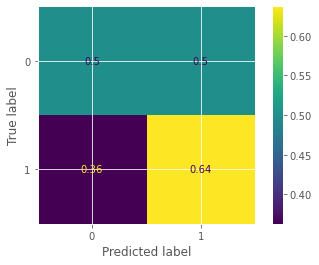

[[147 147]
 [ 70 123]]
              precision    recall  f1-score   support

           0       0.68      0.50      0.58       294
           1       0.46      0.64      0.53       193

    accuracy                           0.55       487
   macro avg       0.57      0.57      0.55       487
weighted avg       0.59      0.55      0.56       487


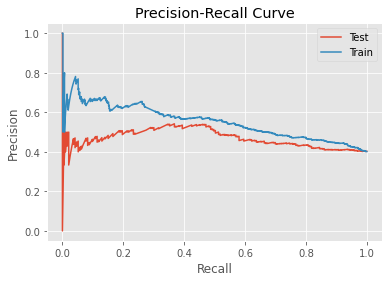

AUPRC Test: 0.47
f1_train: 0.541586 using {'C': 0.5, 'class_weight': 'balanced', 'kernel': 'linear', 'shrinking': True}
f1_test:  0.48847926267281105


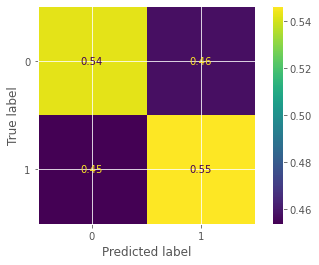

[[159 134]
 [ 88 106]]
              precision    recall  f1-score   support

           0       0.64      0.54      0.59       293
           1       0.44      0.55      0.49       194

    accuracy                           0.54       487
   macro avg       0.54      0.54      0.54       487
weighted avg       0.56      0.54      0.55       487


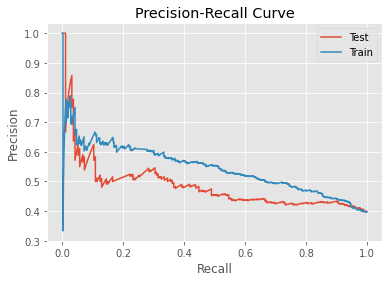

AUPRC Test: 0.48
f1_train: 0.550026 using {'C': 0.5, 'class_weight': 'balanced', 'kernel': 'linear', 'shrinking': False}
f1_test:  0.5626477541371159


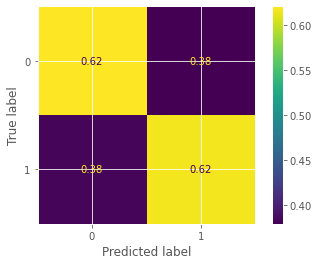

[[182 111]
 [ 74 119]]
              precision    recall  f1-score   support

           0       0.71      0.62      0.66       293
           1       0.52      0.62      0.56       193

    accuracy                           0.62       486
   macro avg       0.61      0.62      0.61       486
weighted avg       0.63      0.62      0.62       486


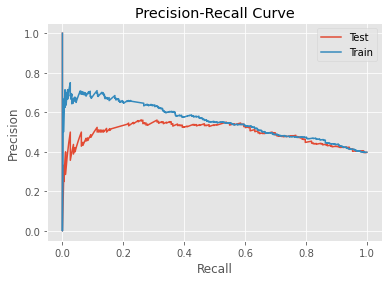

AUPRC Test: 0.49
f1_train: 0.502341 using {'C': 0.5, 'class_weight': 'balanced', 'kernel': 'rbf', 'shrinking': True}
f1_test:  0.5336426914153133


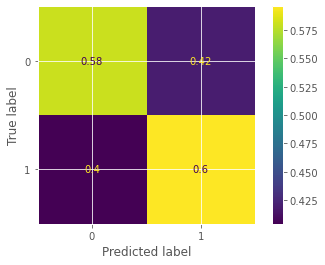

[[170 123]
 [ 78 115]]
              precision    recall  f1-score   support

           0       0.69      0.58      0.63       293
           1       0.48      0.60      0.53       193

    accuracy                           0.59       486
   macro avg       0.58      0.59      0.58       486
weighted avg       0.61      0.59      0.59       486


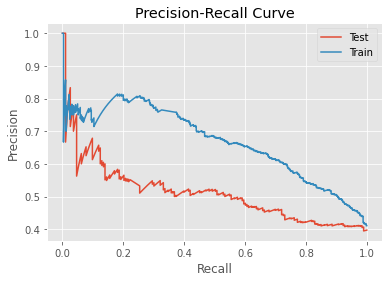

AUPRC Test: 0.51


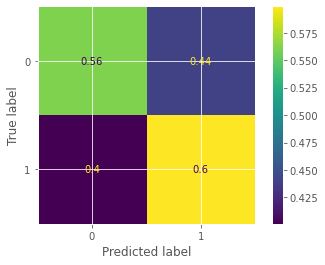

[[658 515]
 [310 463]]
              precision    recall  f1-score   support

           0       0.68      0.56      0.61      1173
           1       0.47      0.60      0.53       773

    accuracy                           0.58      1946
   macro avg       0.58      0.58      0.57      1946
weighted avg       0.60      0.58      0.58      1946


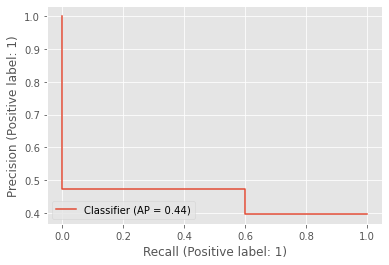

Mean f1 Train: 0.5338821909361064
Mean f1 Test: 0.5290218007064181
Mean AUPRC Test 0.5099060569490209
Mean Precision Test 0.4750876141886746
Mean Recall Test 0.5731310165428837


In [112]:
from sklearn.svm import SVC

model = SVC(probability=True)
parameters={
'kernel': ['linear', 'rbf', 'poly'],
# 'degree': [4, 5,6],
# 'gamma': [0.5,10],
'C': [0.5, 10],
'class_weight': ['balanced'],
'shrinking': [True,False]
}

labels=[]
predictions=[]
f1_sco_train = []
f1_sco=[]
auprc_test = []
prec = []
rec = [] 

# Iterate over the folds
for i in range(len(train_fold)):
    best_model, y_pred, f1_train, f1, auprc, precision, recall = Prediction(model, parameters,  X_train[i], y_train[i], X_test[i], y_test[i])
    f1_sco_train.append(f1_train)
    f1_sco.append(f1)
    labels.append(y_test[i])
    predictions.append(y_pred)
    auprc_test.append(auprc)
    prec.append(precision)
    rec.append(recall)

#  Concatenate the predictions and labels
target=np.concatenate(labels, axis=0)
pred = np.concatenate(predictions, axis=0)

# Compute Mean Scores
f1_mean_train = np.mean(f1_sco_train)
f1_mean=np.mean(f1_sco)
auprc_mean = np.mean(auprc)
prec_mean = np.mean(prec)
rec_mean = np.mean(rec)

plot_confusionMatrix(target, pred)
PrecisionRecallDisplay.from_predictions(target,pred)
plt.show()
print("Mean f1 Train:", f1_mean_train)
print("Mean f1 Test:", f1_mean)
print("Mean AUPRC Test", auprc_mean)
print("Mean Precision Test", prec_mean)
print("Mean Recall Test", rec_mean)

### Logistic Regression

f1_train: 0.532503 using {'C': 0.1, 'class_weight': 'balanced', 'max_iter': 1000}
f1_test:  0.5333333333333332


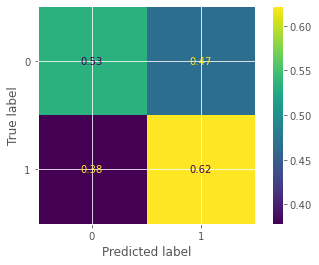

[[157 137]
 [ 73 120]]
              precision    recall  f1-score   support

           0       0.68      0.53      0.60       294
           1       0.47      0.62      0.53       193

    accuracy                           0.57       487
   macro avg       0.57      0.58      0.57       487
weighted avg       0.60      0.57      0.57       487


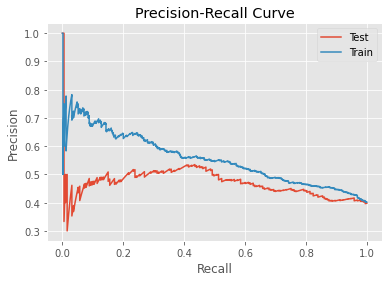

AUPRC Test: 0.47
f1_train: 0.531060 using {'C': 10, 'class_weight': 'balanced', 'max_iter': 1000}
f1_test:  0.5114155251141552


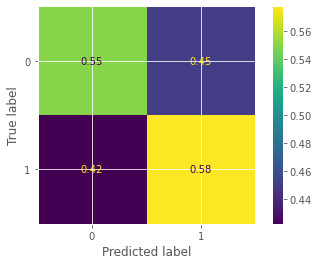

[[161 132]
 [ 82 112]]
              precision    recall  f1-score   support

           0       0.66      0.55      0.60       293
           1       0.46      0.58      0.51       194

    accuracy                           0.56       487
   macro avg       0.56      0.56      0.56       487
weighted avg       0.58      0.56      0.57       487


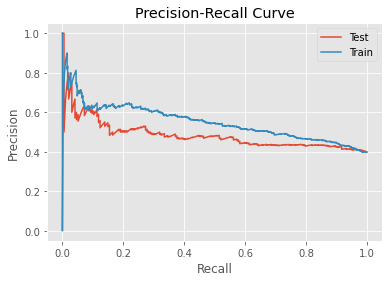

AUPRC Test: 0.48
f1_train: 0.544246 using {'C': 0.1, 'class_weight': 'balanced', 'max_iter': 1000}
f1_test:  0.57002457002457


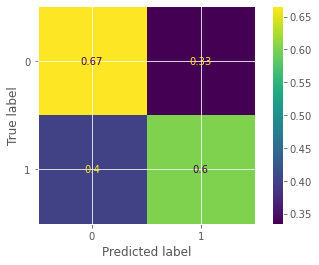

[[195  98]
 [ 77 116]]
              precision    recall  f1-score   support

           0       0.72      0.67      0.69       293
           1       0.54      0.60      0.57       193

    accuracy                           0.64       486
   macro avg       0.63      0.63      0.63       486
weighted avg       0.65      0.64      0.64       486


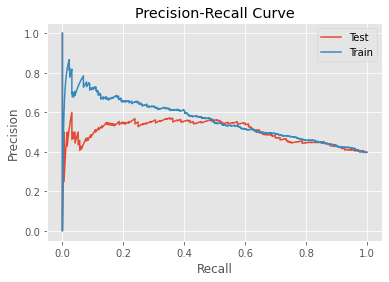

AUPRC Test: 0.50
f1_train: 0.494266 using {'C': 0.01, 'class_weight': 'balanced', 'max_iter': 1000}
f1_test:  0.5012048192771085


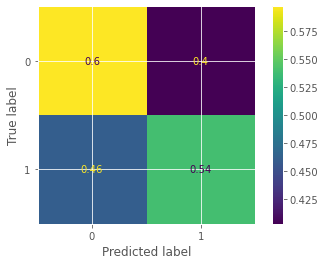

[[175 118]
 [ 89 104]]
              precision    recall  f1-score   support

           0       0.66      0.60      0.63       293
           1       0.47      0.54      0.50       193

    accuracy                           0.57       486
   macro avg       0.57      0.57      0.56       486
weighted avg       0.59      0.57      0.58       486


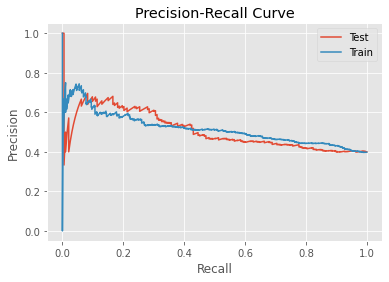

AUPRC Test: 0.51


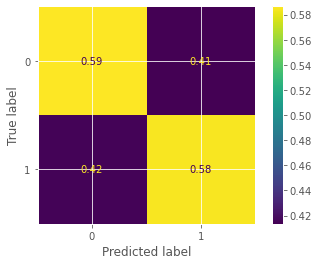

[[688 485]
 [321 452]]
              precision    recall  f1-score   support

           0       0.68      0.59      0.63      1173
           1       0.48      0.58      0.53       773

    accuracy                           0.59      1946
   macro avg       0.58      0.59      0.58      1946
weighted avg       0.60      0.59      0.59      1946


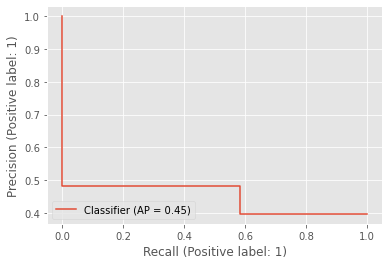

Mean f1 Train: 0.525518659797188
Mean f1 Test: 0.5289945619372917
Mean AUPRC Test 0.5073845304307195
Mean Precision Test 0.47760301639448205
Mean Recall Test 0.562808297714724


In [113]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression()
parameters = {"C":[1e-4,1e-3,1e-2,1e-1,1,10], "max_iter":[1000],'class_weight': ['balanced'] }

labels=[]
predictions=[]
f1_sco_train = []
f1_sco=[]
auprc_test = []
prec = []
rec = [] 

# Iterate over the folds
for i in range(len(train_fold)):
    best_model, y_pred, f1_train, f1, auprc, precision, recall = Prediction(model, parameters,  X_train[i], y_train[i], X_test[i], y_test[i])
    f1_sco_train.append(f1_train)
    f1_sco.append(f1)
    labels.append(y_test[i])
    predictions.append(y_pred)
    auprc_test.append(auprc)
    prec.append(precision)
    rec.append(recall)

#  Concatenate the predictions and labels
target=np.concatenate(labels, axis=0)
pred = np.concatenate(predictions, axis=0)

#Compute Mean Scores
f1_mean_train = np.mean(f1_sco_train)
f1_mean=np.mean(f1_sco)
auprc_mean = np.mean(auprc)
prec_mean = np.mean(prec)
rec_mean = np.mean(rec)

plot_confusionMatrix(target, pred)
PrecisionRecallDisplay.from_predictions(target,pred)
plt.show()
print("Mean f1 Train:", f1_mean_train)
print("Mean f1 Test:", f1_mean)
print("Mean AUPRC Test", auprc_mean)
print("Mean Precision Test", prec_mean)
print("Mean Recall Test", rec_mean)